## Learning Objectives

- Build LLM applications for retrieval-augmented generation tasks.
- Index a folder of documents to a vector database

## Setup

In [1]:
%pip install -q groq tiktoken pypdf langchain langchain-community chromadb sentence-transformers accelerate


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
!python -m pip install --upgrade pip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.0 MB/s eta 0:00:00-:--:--
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# Run only once
# # !unzip /workspaces/AI_ML_GenAI_Training/datasets_rag.zip

In [3]:
import json, pandas as pd, tiktoken

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma

## Creating a Vector Database

### Download Raw Data

In [4]:
# %unzip tesla-annual-reports.zip

### Chunking

Once the choice of embedding model is made, we can feed the input documents to the model. However, since there are multiple pages across documents (including figures, tables) we will need a method to parse individual portions of the document that is aligned with the embedding model.

We also know that the embedding model cannot process text beyond a fixed context length (512 tokens for `gte-large`). This roughly corresponds to about 400 words or about 1 page of text. With this limitation in mind, we will transform the pdf file into chunks of text that are no more than 512 characters long (this is a conservative choice from a token perspective). An alternative method would be to chunk the file by sections in the report (e.g., risk factors, legal proceedings, safety disclosures).

A common chunking strategy is to used a fixed-size chunk as defined by the embedding model and use a small overlap between the chunks (see figure below). Note that the chunk size is number of characters and not number of tokens.


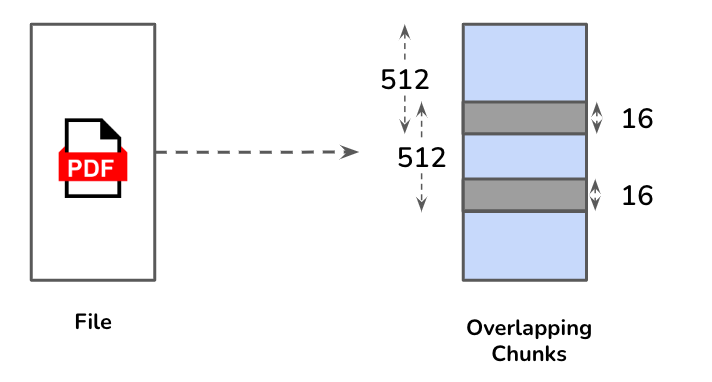

Using an overlap allows for continuity between chunks and retrieval of relevant chunks even when the information relevant to the query is present either at the beginning of the chunk or the end of the chunk.

In [5]:
pdf_folder_location = "datasets_rag"
pdf_loader = PyPDFDirectoryLoader(pdf_folder_location)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(encoding_name='cl100k_base', chunk_size=512, chunk_overlap=16)

In [6]:
data_loader = pdf_loader.load_and_split(text_splitter)
len(data_loader)

114

### Database Creation

In [7]:
data_collection = 'data_collection'
embedding_model = SentenceTransformerEmbeddings(model_name='Qwen/Qwen3-Embedding-0.6B')

/tmp/ipykernel_2666/71882598.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = SentenceTransformerEmbeddings(model_name='Qwen/Qwen3-Embedding-0.6B')
/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
vectorstore = Chroma.from_documents(data_loader, embedding_model, collection_name=data_collection, persist_directory='./tesla_db')
vectorstore.persist()

/tmp/ipykernel_2666/3866711861.py:2: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [9]:
vectorstore_persisted = Chroma(collection_name=data_collection, persist_directory='./tesla_db', embedding_function=embedding_model)
retriever = vectorstore_persisted.as_retriever(search_type='similarity', search_kwargs={'k': 5})

/tmp/ipykernel_2666/1806196826.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore_persisted = Chroma(collection_name=data_collection, persist_directory='./tesla_db', embedding_function=embedding_model)


Zip and download current DB state. This database can then be stored on a server and access could be enabled. In our case, we uploaded the current database state to a Google Drive folder.

In [10]:
!zip -r ./db_vector_data.zip ./tesla_db

  adding: tesla_db/ (stored 0%)
  adding: tesla_db/chroma.sqlite3 (deflated 43%)
  adding: tesla_db/2e6abae3-e077-48b2-877f-87226c936160/ (stored 0%)
  adding: tesla_db/2e6abae3-e077-48b2-877f-87226c936160/length.bin (deflated 100%)
  adding: tesla_db/2e6abae3-e077-48b2-877f-87226c936160/header.bin (deflated 61%)
  adding: tesla_db/2e6abae3-e077-48b2-877f-87226c936160/link_lists.bin (stored 0%)
  adding: tesla_db/2e6abae3-e077-48b2-877f-87226c936160/data_level0.bin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 100%)
